<a href="https://colab.research.google.com/github/dgwalters-1974/autoencoder/blob/main/anomaly_detector_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
# Import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

torch.manual_seed(0)

results_overall = {}

# Load the dataset
file_path = '/content/sample_data/fixings_SmartXM_no empty_max indices.csv'
data = pd.read_csv(file_path)

# Preprocessing: Convert 'Date' to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')
data.set_index('Date', inplace=True)

# Compute daily differences
data_daily_diff = data.diff().dropna()

results_overall['data'] = data
results_overall['data_diff'] = data_daily_diff

In [103]:
currencies = ['JPY', 'EUR', 'USD', 'AUD', 'NZD', 'CAD', 'GBP']

for currency in currencies:

  # Subset the dataset for columns containing 'currency'
  currency_data = data[[col for col in data.columns if currency in col]]

  # Compute daily differences
  currency_daily_diff = currency_data.diff().dropna()

  # Normalize the data
  scaler = MinMaxScaler()
  normalized_currency_data = scaler.fit_transform(currency_daily_diff)

  # Convert to PyTorch tensors
  currency_tensor = torch.tensor(normalized_currency_data, dtype=torch.float32)

  # Split data into training and testing sets
  train_size = int(0.8 * len(currency_tensor))
  test_size = len(currency_tensor) - train_size
  train_data, test_data = torch.utils.data.random_split(currency_tensor, [train_size, test_size])

  train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

  # Define the autoencoder architecture (ix32)(32x4)(4x32)(32xi)
  class Autoencoder(nn.Module):
      def __init__(self, input_dim):
          super(Autoencoder, self).__init__()
          self.encoder = nn.Sequential(
              nn.Linear(input_dim, 32),
              nn.ReLU(),
              nn.Linear(32, 4),
              nn.ReLU()
          )
          self.decoder = nn.Sequential(
              nn.Linear(4, 32),
              nn.ReLU(),
              nn.Linear(32, input_dim),
              nn.Sigmoid()
          )

      def forward(self, x):
          encoded = self.encoder(x)
          decoded = self.decoder(encoded)
          return decoded

  # Instantiate the autoencoder
  input_dim = currency_tensor.shape[1]
  autoencoder = Autoencoder(input_dim)

  # Define the optimizer and loss function
  optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
  criterion = nn.MSELoss()

  # Train the autoencoder
  num_epochs = 50
  for epoch in range(num_epochs):
      autoencoder.train()
      train_loss = 0
      for batch in train_loader:
          optimizer.zero_grad()
          reconstructed = autoencoder(batch)
          loss = criterion(reconstructed, batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      train_loss /= len(train_loader)
      if epoch % 10 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.6f}")

  # Compute reconstruction errors on the entire dataset
  autoencoder.eval()
  with torch.no_grad():
      reconstructed_currency_data = autoencoder(currency_tensor)
      reconstruction_errors = torch.mean((currency_tensor - reconstructed_currency_data) ** 2, dim=1).numpy()

  # Identify anomalies (reconstruction error > 95th percentile)
  threshold = np.percentile(reconstruction_errors, 95)
  anomalies_indices = np.where(reconstruction_errors > threshold)[0]

  # Extract anomalies and add reconstruction errors
  anomalies = currency_daily_diff.iloc[anomalies_indices].copy()
  anomalies['Reconstruction_Error'] = reconstruction_errors[anomalies_indices]

  # Calculate feature contributions based on reconstruction differences
  contributions = np.abs(currency_tensor.numpy() - reconstructed_currency_data.numpy())
  feature_contributions = [dict(zip(currency_daily_diff.columns, contrib)) for contrib in contributions[anomalies_indices]]

  # Add feature contributions to the anomalies dataframe
  anomalies['Feature_Contributions'] = feature_contributions

  # Prepare the final anomalies table
  result_table = anomalies.reset_index()[['Date', 'Reconstruction_Error', 'Feature_Contributions']]

  # Display the result table
  #print(result_table.head())

  results_overall[currency] = result_table.sort_values('Date')




Epoch 1/50, Loss: 0.003951
Epoch 11/50, Loss: 0.002039
Epoch 21/50, Loss: 0.001480
Epoch 31/50, Loss: 0.001164
Epoch 41/50, Loss: 0.001011
Epoch 1/50, Loss: 0.070415
Epoch 11/50, Loss: 0.004319
Epoch 21/50, Loss: 0.004092
Epoch 31/50, Loss: 0.002935
Epoch 41/50, Loss: 0.001235
Epoch 1/50, Loss: 0.003172
Epoch 11/50, Loss: 0.001559
Epoch 21/50, Loss: 0.001191
Epoch 31/50, Loss: 0.000943
Epoch 41/50, Loss: 0.000847
Epoch 1/50, Loss: 0.004746
Epoch 11/50, Loss: 0.001959
Epoch 21/50, Loss: 0.001420
Epoch 31/50, Loss: 0.001324
Epoch 41/50, Loss: 0.001290
Epoch 1/50, Loss: 0.002926
Epoch 11/50, Loss: 0.001538
Epoch 21/50, Loss: 0.000411
Epoch 31/50, Loss: 0.000314
Epoch 41/50, Loss: 0.000260
Epoch 1/50, Loss: 0.004056
Epoch 11/50, Loss: 0.001324
Epoch 21/50, Loss: 0.000562
Epoch 31/50, Loss: 0.000411
Epoch 41/50, Loss: 0.000305
Epoch 1/50, Loss: 0.003533
Epoch 11/50, Loss: 0.002492
Epoch 21/50, Loss: 0.002507
Epoch 31/50, Loss: 0.002520
Epoch 41/50, Loss: 0.002482


In [104]:
def plot_results(plot_data, currency, anomalies):
  currency_data = plot_data[[col for col in plot_data.columns if currency in col]]
  for feature in currency_data.columns:
      plt.figure(figsize=(12, 6))

      # Plot the main line for the feature
      plt.plot(currency_data.index, currency_data[feature], label=feature, color='steelblue', alpha=0.7, linewidth=1.5)

      # Highlight anomalies
      anomaly_dates = anomalies['Date']
      anomaly_values = currency_data.loc[anomaly_dates, feature]
      plt.scatter(anomaly_dates, anomaly_values, color='darkred', label='Anomalies', zorder=5, s=30, alpha=0.8)

      # Add chart aesthetics
      plt.title(f"{feature} vs Date with Anomalies Highlighted", fontsize=14, fontweight='bold')
      plt.xlabel("Date", fontsize=12)
      plt.ylabel(feature, fontsize=12)
      plt.legend()
      plt.grid(alpha=0.3)
      plt.tight_layout()

      # Display the plot
      plt.show()




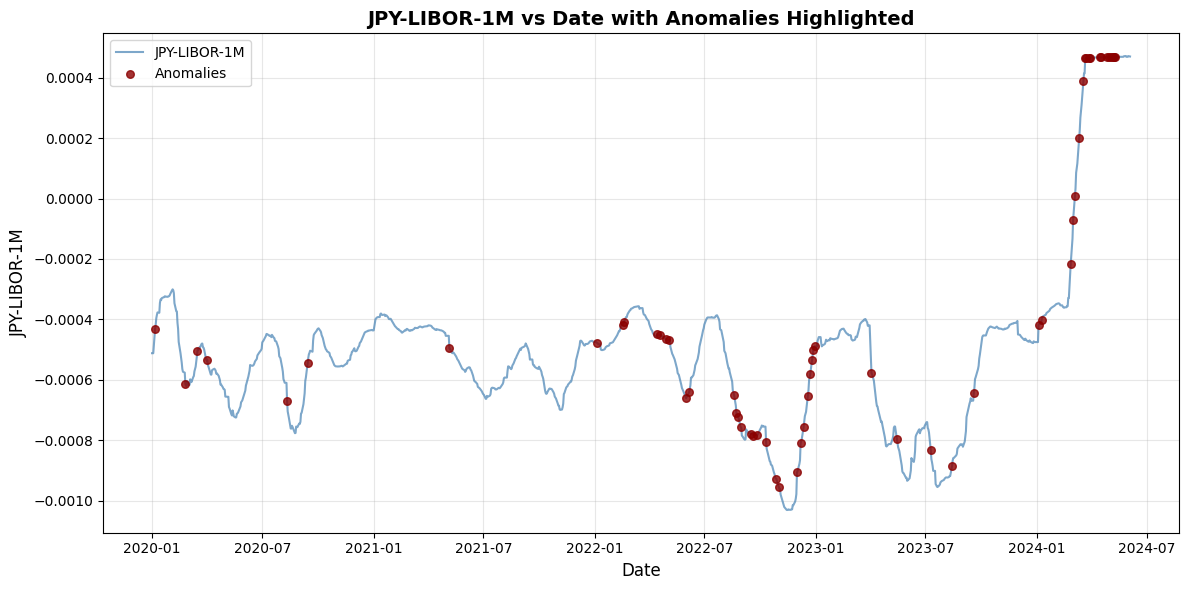

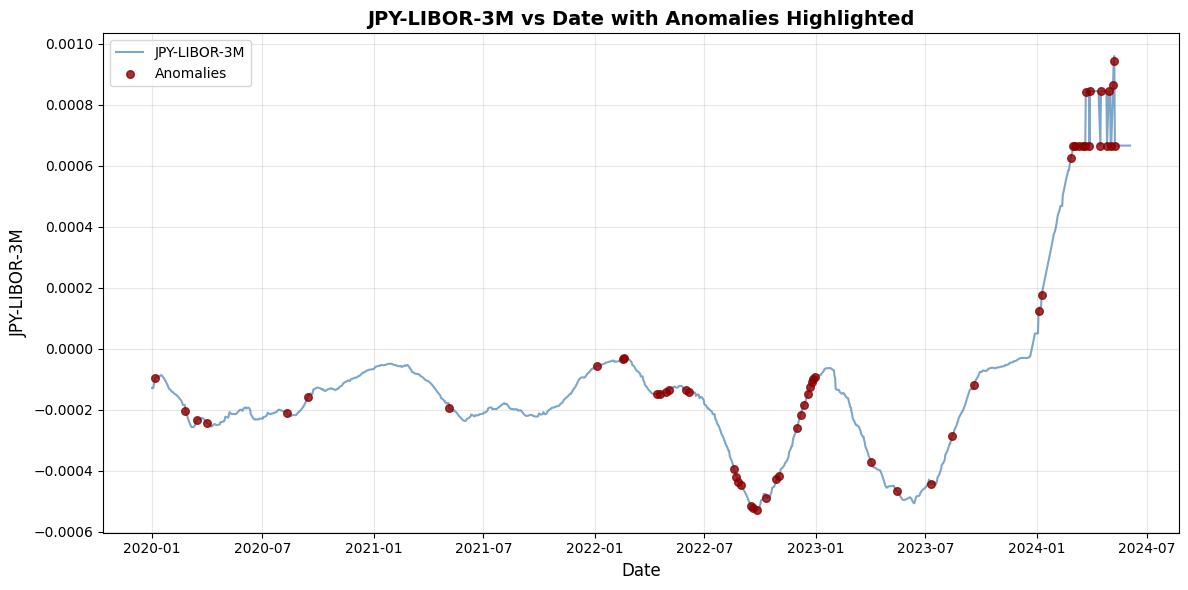

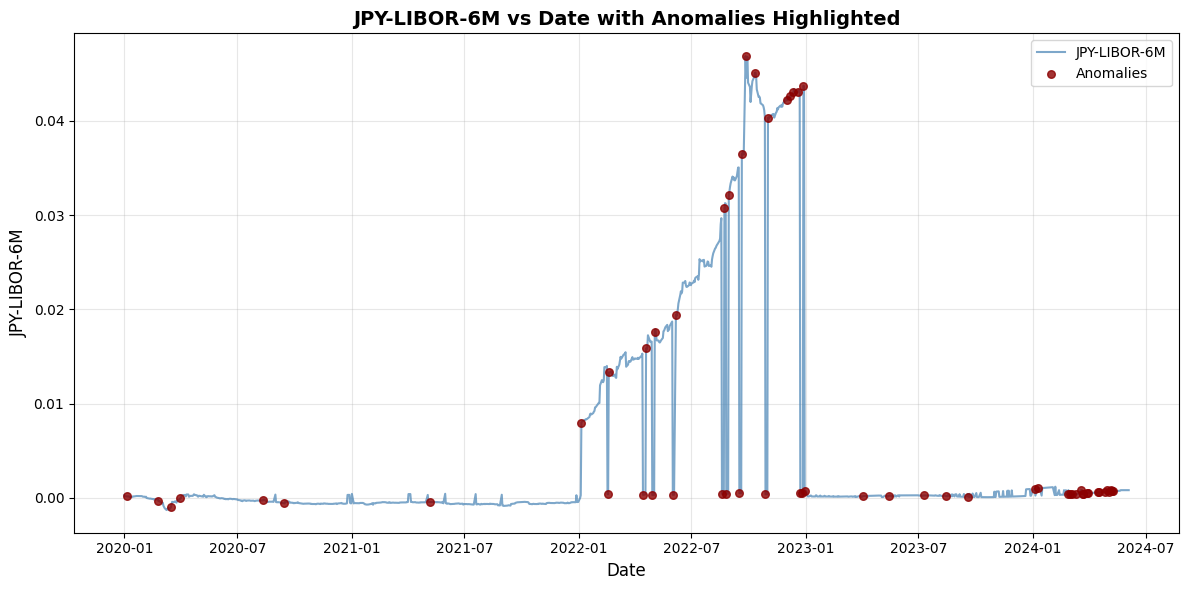

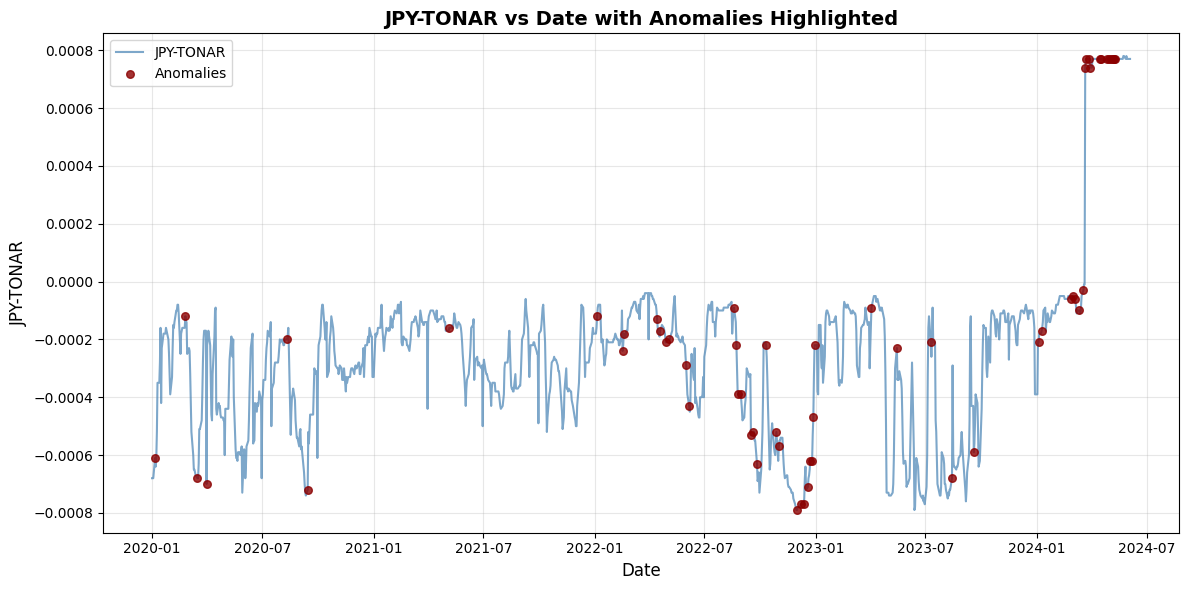

In [105]:
plot_data = results_overall['data'] # Plot outright data
currency = 'JPY'
anomalies = results_overall[currency]

plot_results(plot_data, currency, anomalies)

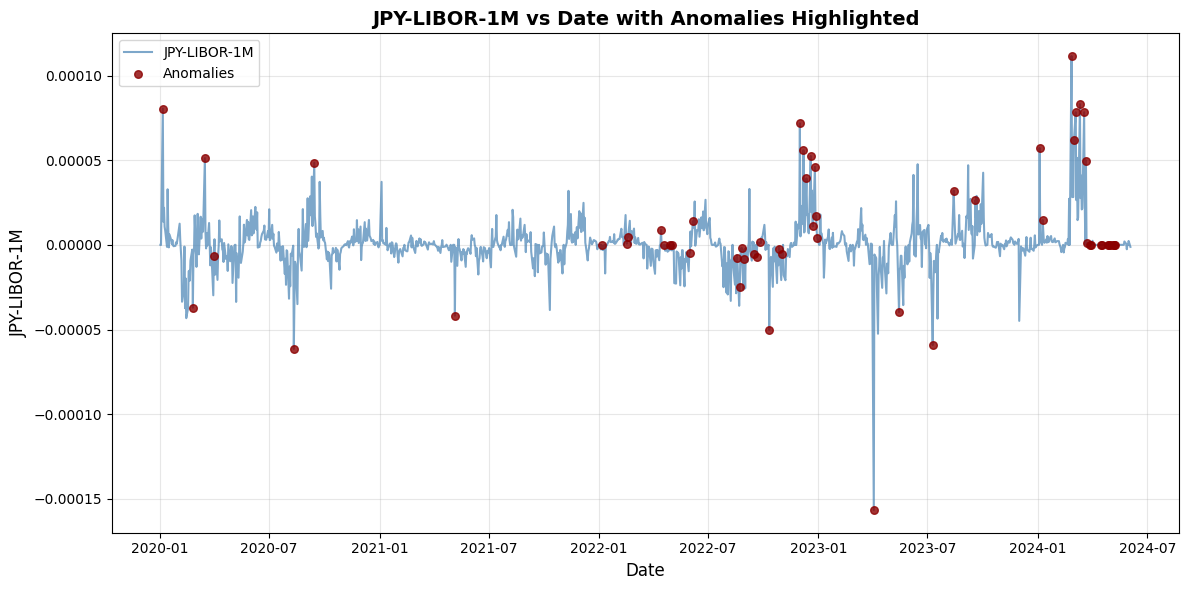

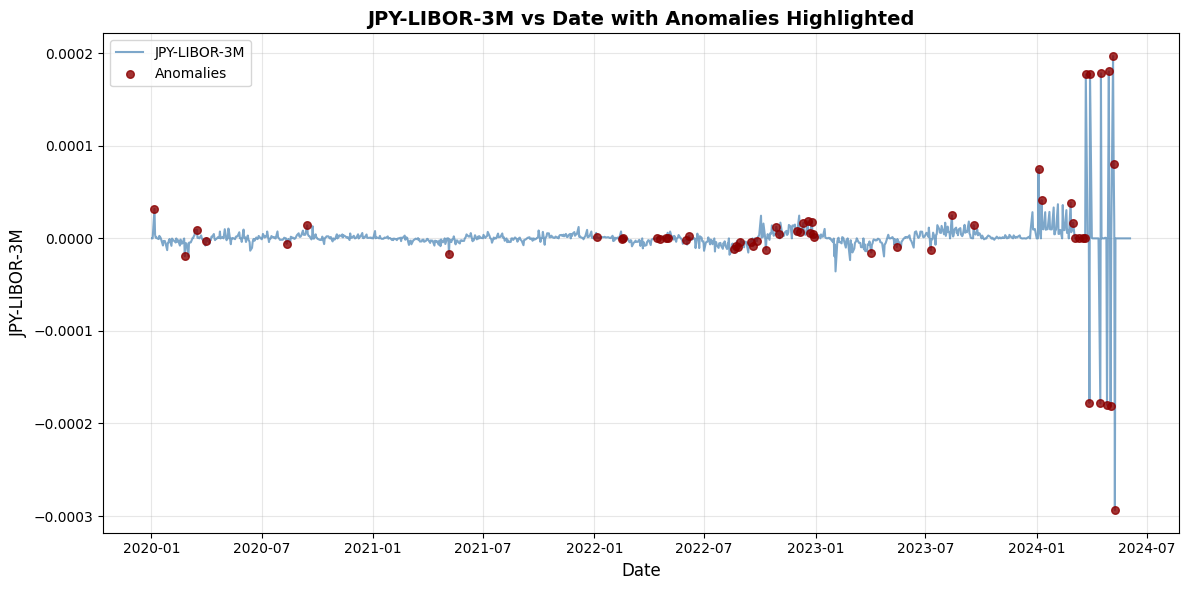

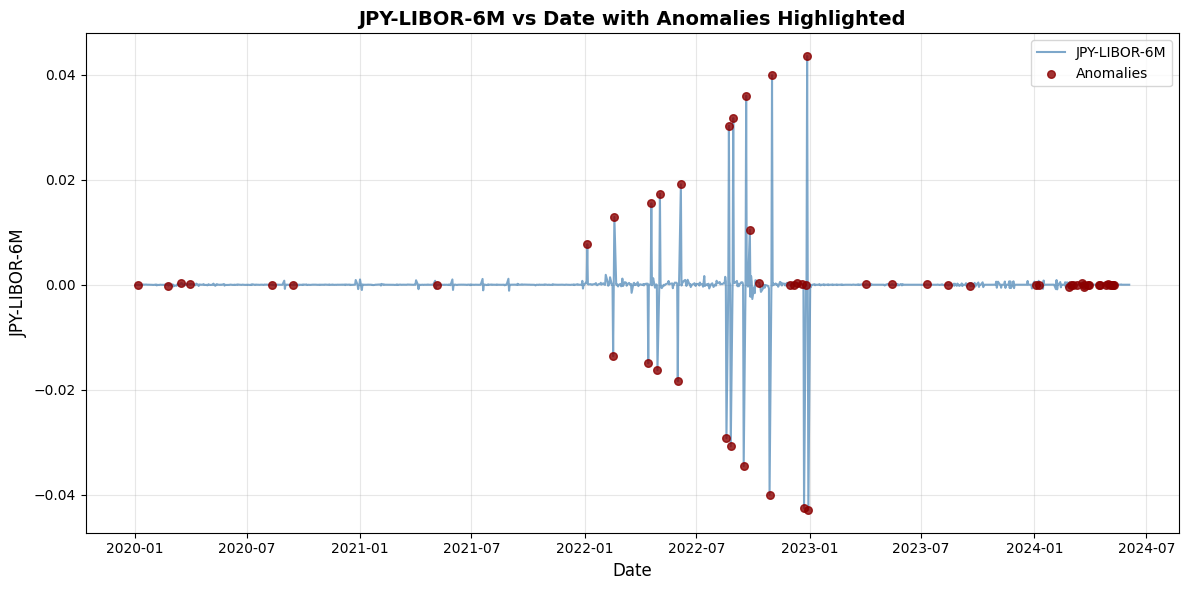

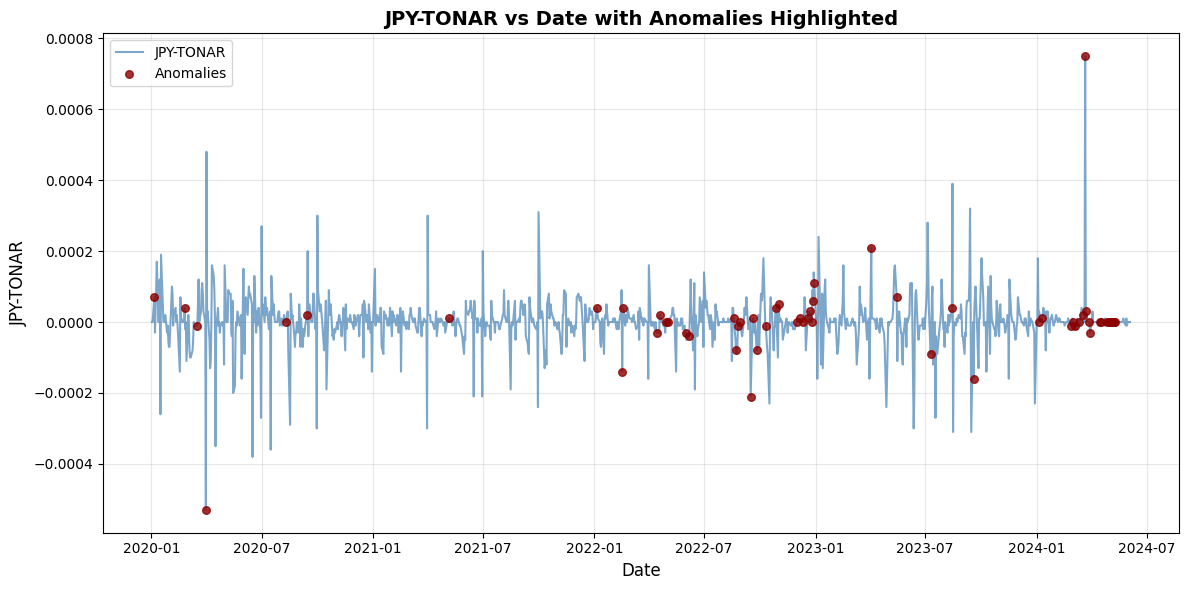

In [106]:
plot_data = results_overall['data_diff'] # Plot outright data
currency = 'JPY'
anomalies = results_overall[currency]
plot_results(plot_data, currency, anomalies)

In [107]:
# Not really sure if this is a good measure of how 'anomalous' the data is
overall_anomaly_score = {}

for curr in currencies:
  overall_anomaly_score[curr] = results_overall[curr]['Reconstruction_Error'].mean()

In [108]:
overall_anomaly_score

{'JPY': 0.01829164,
 'EUR': 0.010768742,
 'USD': 0.012499409,
 'AUD': 0.016643979,
 'NZD': 0.005831714,
 'CAD': 0.0033604673,
 'GBP': 0.040735092}

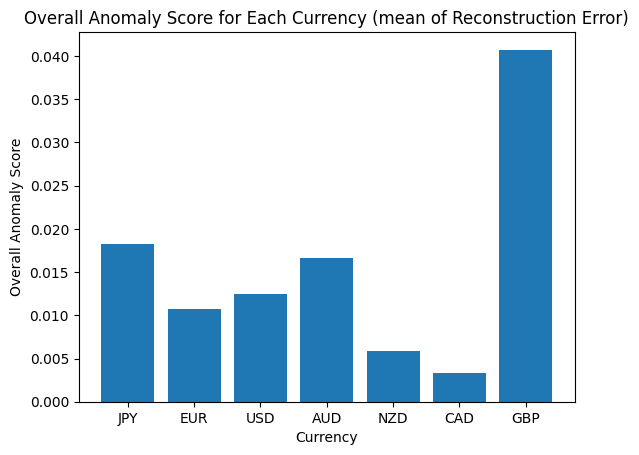

In [109]:
# Plot the 'overall' anomaly scores to get an idea about relative behaviour of each currency

import matplotlib.pyplot as plt

# D = {u'Label1':26, u'Label2': 17, u'Label3':30}

plt.bar(range(len(overall_anomaly_score)), list(overall_anomaly_score.values()), align='center')
plt.xticks(range(len(overall_anomaly_score)), list(overall_anomaly_score.keys()))
plt.xlabel('Currency')
plt.ylabel('Overall Anomaly Score')
plt.title('Overall Anomaly Score for Each Currency (mean of Reconstruction Error)')
plt.show();

## Closer look at JPY data to see what's going on...

<ipython-input-110-66edabd4eb2b>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


Epoch 1/50, Loss: 0.103386
Epoch 11/50, Loss: 0.009353
Epoch 21/50, Loss: 0.002995
Epoch 31/50, Loss: 0.002613
Epoch 41/50, Loss: 0.002121


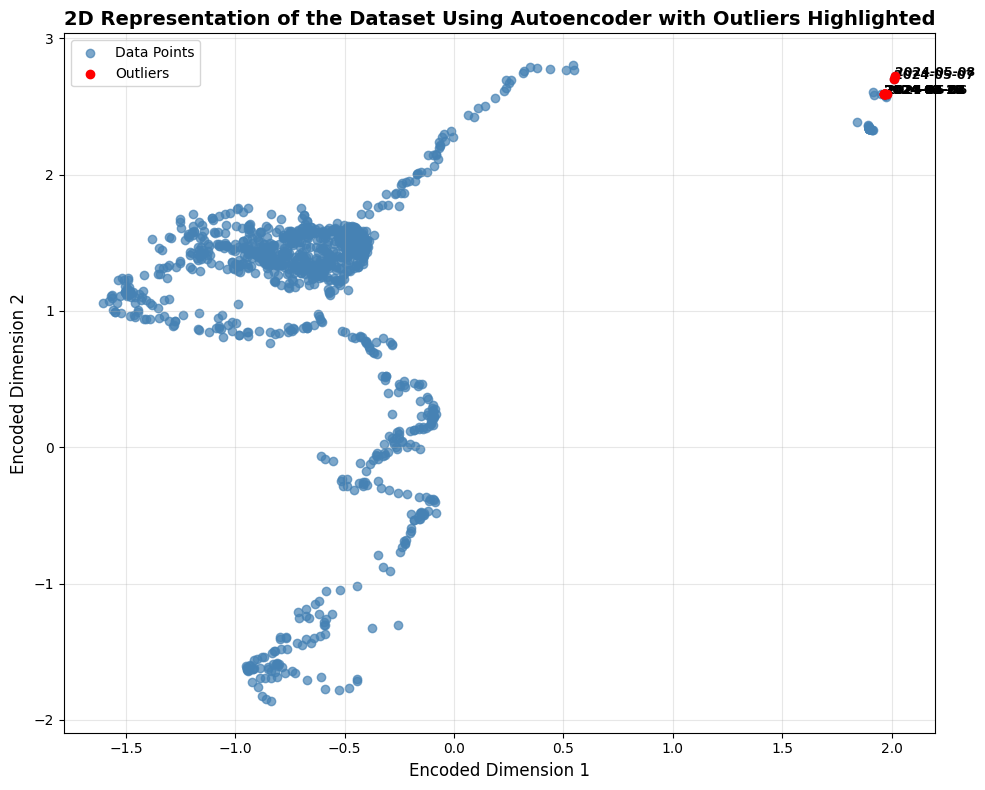

In [110]:
# Importing necessary libraries
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)

# Load the uploaded dataset
file_path = '/content/sample_data/test_jpy.csv'
data = pd.read_csv(file_path)

# Preprocessing: Convert 'Date' to datetime and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

# Convert the normalized data to PyTorch tensors
data_tensor = torch.tensor(normalized_data, dtype=torch.float32)

# Define the autoencoder architecture with 2D encoding
class Autoencoder2D(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder2D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Reduce to 2 dimensions
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Instantiate the autoencoder
input_dim = data_tensor.shape[1]
autoencoder_2d = Autoencoder2D(input_dim)

# Define optimizer and loss function
optimizer = torch.optim.Adam(autoencoder_2d.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training the autoencoder
num_epochs = 50
batch_size = 32
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    autoencoder_2d.train()
    epoch_loss = 0
    for batch in data_loader:
        optimizer.zero_grad()
        batch_data = batch[0]
        encoded, decoded = autoencoder_2d(batch_data)
        loss = criterion(decoded, batch_data)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(data_loader)
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}")

# Reduce the dataset to 2 dimensions using the encoder
autoencoder_2d.eval()
with torch.no_grad():
    reduced_data = autoencoder_2d.encoder(data_tensor).numpy()

# Scatter plot of the 2D encoded variables
# plt.figure(figsize=(10, 8))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, c='steelblue')
# plt.title('2D Representation of the Dataset Using Autoencoder', fontsize=14, fontweight='bold')
# plt.xlabel('Encoded Dimension 1', fontsize=12)
# plt.ylabel('Encoded Dimension 2', fontsize=12)
# plt.grid(alpha=0.3)
# plt.show()
# Scatter plot of the 2D encoded variables with date labels for outliers
plt.figure(figsize=(10, 8))

# Plot the 2D encoded data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, c='steelblue', label='Data Points')

# Calculate distances from the origin as a measure of "outlierness"
distances = np.sqrt(reduced_data[:, 0]**2 + reduced_data[:, 1]**2)

# Find indices of the 10 most significant outliers
outlier_indices = np.argsort(distances)[-10:]
outlier_dates = data.index[outlier_indices]

# Highlight and label outliers
plt.scatter(reduced_data[outlier_indices, 0], reduced_data[outlier_indices, 1], color='red', label='Outliers', zorder=5)
for i, idx in enumerate(outlier_indices):
    plt.text(
        reduced_data[idx, 0],
        reduced_data[idx, 1],
        outlier_dates[i].strftime('%Y-%m-%d'),
        fontsize=9,
        color='black',
        weight='bold'
    )

# Plot aesthetics
plt.title('2D Representation of the Dataset Using Autoencoder with Outliers Highlighted', fontsize=14, fontweight='bold')
plt.xlabel('Encoded Dimension 1', fontsize=12)
plt.ylabel('Encoded Dimension 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


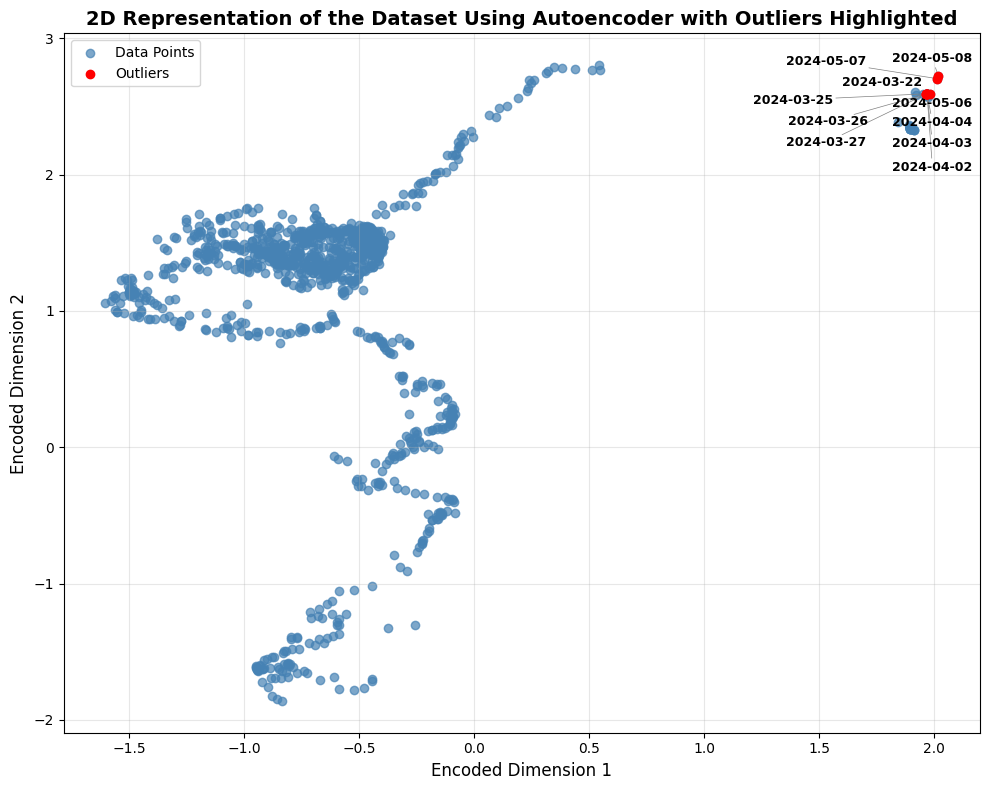

In [111]:
!pip install adjustText
# Importing the required library for label adjustment
from adjustText import adjust_text

# Scatter plot of the 2D encoded variables with date labels for outliers
plt.figure(figsize=(10, 8))

# Plot the 2D encoded data
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, c='steelblue', label='Data Points')

# Calculate distances from the origin as a measure of "outlierness"
distances = np.sqrt(reduced_data[:, 0]**2 + reduced_data[:, 1]**2)

# Find indices of the 10 most significant outliers
outlier_indices = np.argsort(distances)[-10:]
outlier_dates = data.index[outlier_indices]

# Highlight and label outliers
plt.scatter(reduced_data[outlier_indices, 0], reduced_data[outlier_indices, 1], color='red', label='Outliers', zorder=5)

# Prepare labels and positions for adjustment
texts = []
for i, idx in enumerate(outlier_indices):
    texts.append(
        plt.text(
            reduced_data[idx, 0],
            reduced_data[idx, 1],
            outlier_dates[i].strftime('%Y-%m-%d'),
            fontsize=9,
            color='black',
            weight='bold'
        )
    )

# Adjust text to avoid overlapping
adjust_text(
    texts,
    x=reduced_data[outlier_indices, 0],
    y=reduced_data[outlier_indices, 1],
    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5)
)

# Plot aesthetics
plt.title('2D Representation of the Dataset Using Autoencoder with Outliers Highlighted', fontsize=14, fontweight='bold')
plt.xlabel('Encoded Dimension 1', fontsize=12)
plt.ylabel('Encoded Dimension 2', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()


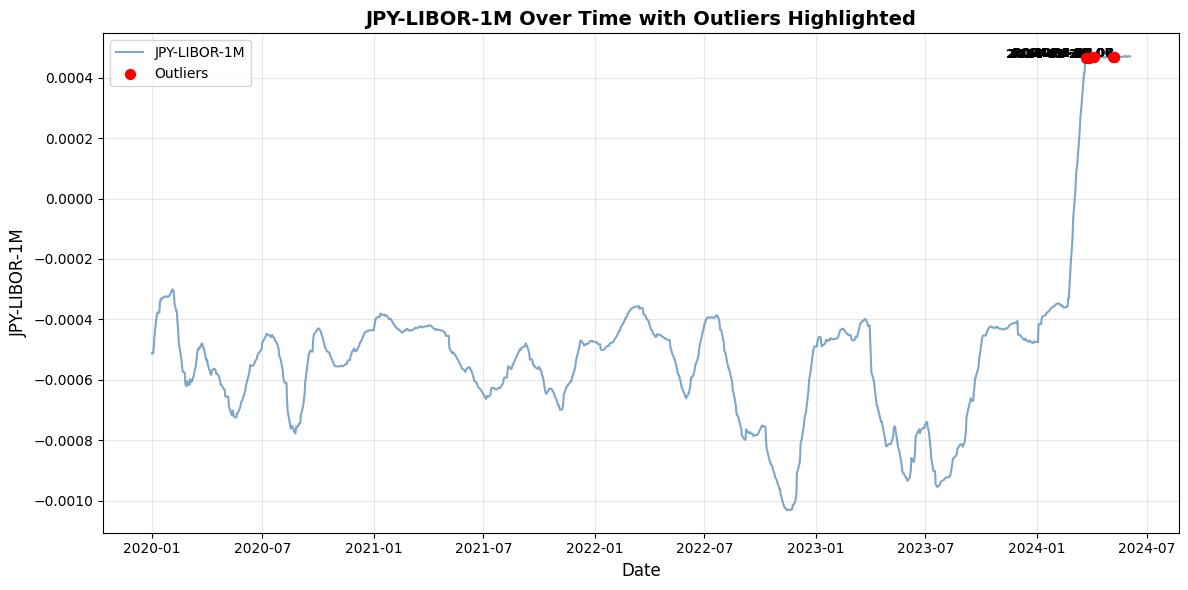

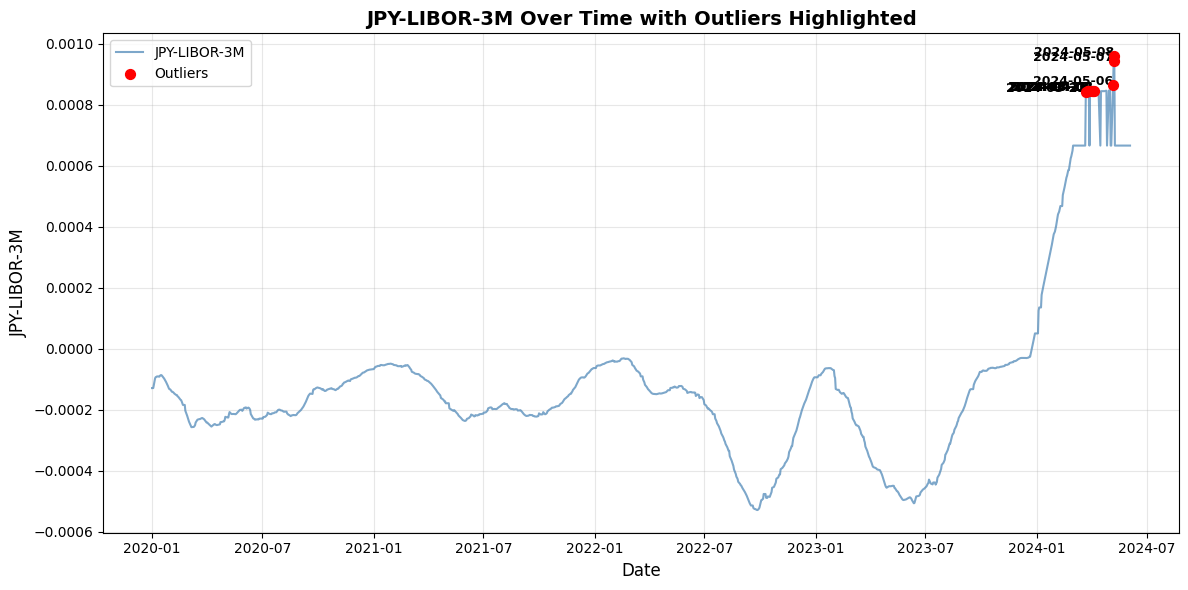

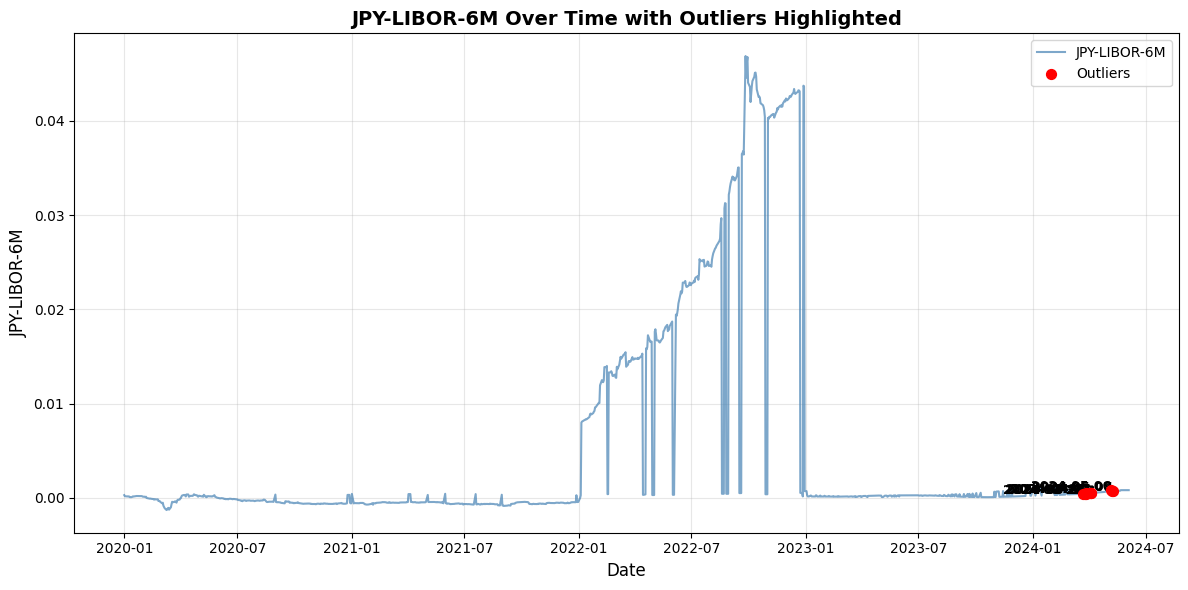

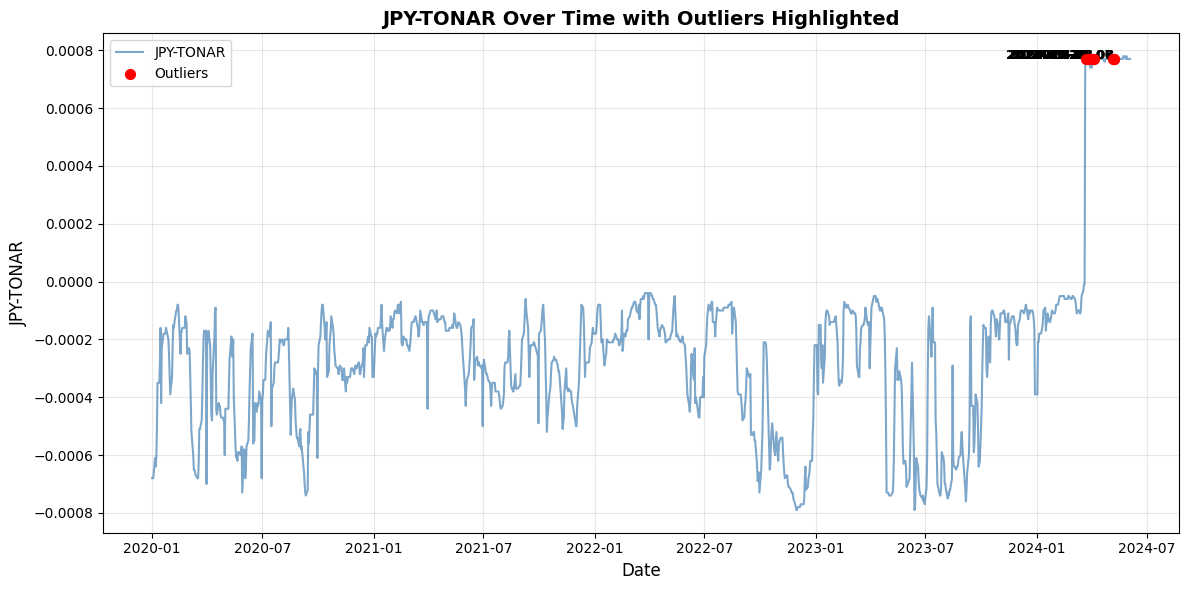

In [112]:
# Highlight the same outliers on line plots of the original features
outlier_dates_list = data.index[outlier_indices]

# Iterate through each feature and plot
for feature in data.columns:
    plt.figure(figsize=(12, 6))

    # Plot the time series of the feature
    plt.plot(data.index, data[feature], label=feature, color='steelblue', alpha=0.7, linewidth=1.5)

    # Highlight the outlier points
    outlier_values = data.loc[outlier_dates_list, feature]
    plt.scatter(outlier_dates_list, outlier_values, color='red', label='Outliers', zorder=5, s=50)

    # Annotate the outliers with dates
    for date, value in zip(outlier_dates_list, outlier_values):
        plt.text(
            date, value,
            date.strftime('%Y-%m-%d'),
            fontsize=9,
            color='black',
            weight='bold',
            ha='right'
        )

    # Aesthetics
    plt.title(f"{feature} Over Time with Outliers Highlighted", fontsize=14, fontweight='bold')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()
